In [1]:
# An attempt to visualise the APS demo using VPython
from vpython import *
import numpy as np
import math

<IPython.core.display.Javascript object>

In [ ]:
def square_matrix(arr):
    retM = np.zeros((len(arr), len(arr)))
    for index in range(len(arr)):
        retM[index][index] = np.real(arr[index])
    return retM

def mds(dists):
    numPoints = len(dists)
    C = np.eye(len(dists)) - (np.ones((len(dists), len(dists)))/len(dists))  # centering matrix C
    Dsquared = np.zeros((len(dists), len(dists))) # piece-wise squared distance matrix
    for i in range(len(dists)):
        for j in range(len(dists)):
            Dsquared[i][j] = (dists[i][j]*dists[i][j])
    B = -0.5*np.linalg.multi_dot((C,Dsquared,C))  # B = -0.5*C*D^(2)*C

    ret = np.linalg.eig(B)
    # Get m largest eigenvalues
    theoreticalEigenValues = np.argsort(ret.eigenvalues)[-2:]  # Get largest eigenvalues/vectors
    # print(theoreticalEigenValues)
    eigenValues = ret.eigenvalues[theoreticalEigenValues]
    # And corresponding eigenvectors
    eigenVectors = ret.eigenvectors[:, theoreticalEigenValues]
    eigenVectors = eigenVectors / np.linalg.norm(eigenVectors, axis=0, ord=2)
    d2c = (np.dot(eigenVectors, np.sqrt(square_matrix(eigenValues))))  # Recalculate new points
    # d2c = np.asmatrix(d2c)

    newdists = np.zeros((numPoints, numPoints))
    for i in range(numPoints):
        for j in range(numPoints):
            newdists[i][j] = (np.linalg.norm(d2c[i] - d2c[j]))

    rmse = 0  # Calculate difference between initial data and answer to geometry
    for i in range(numPoints):
        for j in range(numPoints):
            rmse += ((dists[i][j]-newdists[i][j])**2)/(numPoints**2)

    rmse = math.sqrt(rmse)
    d2c = np.real(d2c)
    # print(d2c)
    return d2c, rmse

class Tree:
    def __init__(self, pos):
        self.pos = pos
        self.stump = cylinder(pos = self.pos, size = vector(10, 2.5, 2.5), axis=vector(0,1,0), color= vector(150/255, 75/255, 0))
        self.leaves = []
        self.numleaves = 2
        for i in range(self.numleaves):
            self.leaves.append(cone(pos = self.pos+vector(0, (1+(i/self.numleaves))*5, 0), length=5, radius=0.75*5, axis=vector(0,1,0), color=color.green))
        self.tree = compound([self.stump] + self.leaves)

class Node:
    def __init__(self, pos, scalefactor = 1, alpha=1, opacity=1):
        self.pos = pos
        self.base1 = cylinder(pos = self.pos, size = vector(0.04, 0.13, 0.13)*scalefactor, axis = vector(0,1,0), color=color.red, alpha=alpha, opacity=opacity)
        self.base2 = cone(pos=self.pos+vector(0, 0.04*scalefactor, 0), length=0.014*scalefactor, radius=0.065*scalefactor, axis = vector(0,1,0), color=color.black, alpha=alpha, opacity=opacity)
        self.base3 = cylinder(pos=self.pos+vector(0, 0.04*scalefactor, 0), size=vector(.014, 0.114, 0.114)*scalefactor, axis=vector(0,1,0), color=color.white, alpha=alpha, opacity=opacity)
    def diff(self, node2):
        pos1 = np.asarray((self.pos.x, self.pos.y, self.pos.z))
        pos2 = np.asarray((node2.pos.x, node2.pos.y, node2.pos.z))
        return np.linalg.norm(pos1 - pos2)
class Skybox:
    def __init__(self):
        # Sky boxes
        hshape1 = shapes.arc(angle1=0, angle2=pi/2, radius=islandwidth*1.5, thickness=0.01)
        hpath1 = paths.circle(radius=0.5)
        demihemi1 = extrusion( shape=hshape1, path=hpath1, color=color.cyan)

        hshape2 = shapes.arc(angle1=0, angle2=-1*pi/2, radius=islandwidth*1.5, thickness=0.01)
        hpath2 = paths.circle(radius=0.5)
        demihemi2 = extrusion( shape=hshape2, path=hpath2, color=color.black)

In [ ]:
# pyqt can't be used on windows? Look into work around
set_browser(type='pyqt')
scene = canvas(width=1200, height=900)
scene.align = 'left'
# scene.caption = """In GlowScript programs:
# Right button drag or Ctrl-drag to rotate "camera" to view scene.
# To zoom, drag with middle button or Alt/Option depressed, or use scroll wheel.
#   On a two-button mouse, middle is left + right.
# Touch screen: pinch/extend to zoom, swipe or two-finger rotate."""
scene.background = color.white
scene.forward = vector(0,-.3,-1)
scene.autoscale = False
scene.userzoom = False


islandwidth = 100
phi = (1 + np.sqrt(5)) / 2


# Add in an environment and populate it with trees
ground = cylinder(pos=vector(0, -1, 0), size = vector(1, islandwidth, islandwidth), axis=vector(0, 1,0), color = color.yellow)
dirt = cylinder(pos=vector(0, -1.1, 0), size = vector(1, islandwidth+1, islandwidth+1), axis=vector(0, 1, 0), color=vector(150/255, 75/255, 0))
trees = []
numtrees = 15
for i in range(numtrees):
    trees.append(Tree(vector(.45*islandwidth*np.cos(i*phi*2*np.pi/numtrees),0, .45*islandwidth*np.sin(i*phi*2*np.pi/numtrees))))

# Instantiate each node on the grass
nodes = []
for i in range(5):
    for j in range(5):
        nodes.append(Node(vector(3*i - 6, 0, 3*j - 6), 5))

Skybox()

rad = sphere(pos = nodes[0].pos, opacity=0.2, radius = 0, color=color.red)


# Logic for animating the demonstration
print(nodes[0].diff(nodes[1]))
dists = [ [0.0 for i in range(len(nodes))] for i in range(len(nodes))]
def mat_to_str(mat):
    retstr = ""
    for row in mat:
        for column in row:
            retstr += f"{column:05.2f}" + ", "
        retstr += "\n"
    return retstr

radpos = 0

while True:
    rate(60)
    if rad.radius < 10:
        rad.radius += (6/6)
    elif radpos+1 < len(nodes):
        rad.radius = 0
        for i, node in enumerate(nodes):
            dists[radpos][i] = nodes[radpos].diff(node)
        # print(dists[radpos])
        # l.text = mat_to_str(dists)
        radpos += 1
        rad.pos = nodes[radpos].pos
    elif rad.visible:
        for i, node in enumerate(nodes):
            dists[radpos][i] = nodes[radpos].diff(node)
        # print(dists[radpos])
        # l.text = mat_to_str(dists)
        rad.visible = False
        d2c, rmse = mds(dists)
        print("RMSE: ", rmse)
        newnodes = []
        for coord in d2c:
            newnodes.append(Node(vector(coord[0], 0, coord[1]), scalefactor=5, opacity=0.5))
        # print("nodes created?")

In [ ]:
import os
import wave
import shutil
import struct
import numpy as np
import math
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import sys

# Notes from Dr. Xiao meeting
# Check math on eigenvector decomposition, rank of 100x100 proximity matrix
# Max/min of eigenvalues/vectors
# Run MDS multiple times, compare answers, see if they're unique

# Todo from Dr. Hanieh
# Use match filters (I.E., transfer-functioned value using 5second wav)
# Use 5 second white noise
# More accurate accoustic propogation (
# Consider only nearest neighbors (Nearest 8? Maybe nearest 26?)


def get_pos(n):
    #0 is bottom left, 1 is directly to the right, last is topright most...
    i, j = n%width, int(n/height)
    return poss[i][j][0], poss[i][j][1]

def get_timedelay(x, y):
    global samplingrate, speedofsound
    # Distance between points x and y, so
    posx = get_pos(x)
    posy = get_pos(y)
    distance = math.dist(posx, posy) # euclidian distance in meters
    timedelay = distance / speedofsound # distance / speedofsound = timedelay
    numsamples = int(timedelay * samplingrate) # timedelay is in seconds, samplingrate is in Hz, round down
    return numsamples # We want the final timedelay in numsamples

def cross_correlate(fullsound, signal):
    lenfull, lensignal = len(fullsound), len(signal)
    # fullsound = fullsound.astype(np.int64)
    signal = signal.astype(np.int64)
    corrs = []
    full = []
    for offset in range(0, lenfull-lensignal, 1):
        # sum = np.dot(signal, fullsound[offset:offset+lensignal])
        # corrs.append(sum)
        full.append(fullsound[offset:offset+lensignal])
    full = np.asarray(full)
    corrs = np.dot(full, signal)
    # print(corrs)
    return corrs

def square_matrix(arr):
    retM = np.zeros((len(arr), len(arr)))
    for index in range(len(arr)):
        retM[index][index] = np.real(arr[index])
    return retM

def mds(dists):
    numPoints = len(dists)
    C = np.eye(len(dists)) - (np.ones((len(dists), len(dists)))/len(dists))  # centering matrix C
    Dsquared = np.zeros((len(dists), len(dists))) # piece-wise squared distance matrix
    for i in range(len(dists)):
        for j in range(len(dists)):
            Dsquared[i][j] = (dists[i][j]*dists[i][j])
    B = -0.5*np.linalg.multi_dot((C,Dsquared,C))  # B = -0.5*C*D^(2)*C

    ret = np.linalg.eig(B)
    # Get m largest eigenvalues
    theoreticalEigenValues = np.argsort(ret.eigenvalues)[-2:]  # Get largest eigenvalues/vectors
    # print(theoreticalEigenValues)
    eigenValues = ret.eigenvalues[theoreticalEigenValues]
    # And corresponding eigenvectors
    eigenVectors = ret.eigenvectors[:, theoreticalEigenValues]
    eigenVectors = eigenVectors / np.linalg.norm(eigenVectors, axis=0, ord=2)
    d2c = (np.dot(eigenVectors, np.sqrt(square_matrix(eigenValues))))  # Recalculate new points
    # d2c = np.asmatrix(d2c)

    newdists = np.zeros((numPoints, numPoints))
    for i in range(numPoints):
        for j in range(numPoints):
            newdists[i][j] = (np.linalg.norm(d2c[i] - d2c[j]))

    rmse = 0  # Calculate difference between initial data and answer to geometry
    for i in range(numPoints):
        for j in range(numPoints):
            rmse += ((dists[i][j]-newdists[i][j])**2)/(numPoints**2)

    rmse = math.sqrt(rmse)
    d2c = np.real(d2c)
    # print(d2c)
    fig4, ax4 = plt.subplots(1, 1)
    ax4.scatter(d2c[:, 0], d2c[:, 1])
    for i in range(numbernodes):
        ax4.annotate(i, (d2c[:, 0][i], d2c[:, 1][i]))
    fig4.savefig("fig4")
    return rmse

def animate_cross_correlate(fullsound, signal, corrs):
    lenfull, lensignal = len(fullsound), len(signal)
    print("Signal: ", signal)
    animfig, (animax1, animax2) = plt.subplots(2,1)
    lines = [animax1.plot([], [])[0] for _ in range(2)] + [animax2.plot([], [])[0]] #lines to animate

    def init():
        animax1.set_xlim(0, lenfull)
        animax1.set_ylim(-10000, 10000)
        animax2.set_xlim(0, lenfull)
        animax2.set_ylim(-40000000000, 40000000000)
        xdata = [i for i in range(lenfull)]
        ydata = fullsound
        lines[1].set_data(xdata, ydata)
        return lines
    def update(frame):
        xdata = [(frame + i ) % lenfull for i in range(lensignal)]
        ydata = signal
        xdata2 = [i for i in range(int(frame))]
        ydata2 = corrs[0:int(frame)]
        lines[0].set_data(xdata, ydata)
        lines[2].set_data(xdata2, ydata2)
        return lines
    ani = FuncAnimation(animfig, update, frames=np.linspace(0, lenfull-lensignal, num=100), init_func = init, blit=True)
    writergif = animation.PillowWriter(fps=30)
    ani.save("animation.gif", writer=writergif)
    exit()


def cross_correlate2(fullsound, signal):
    lenfull, lensignal = len(fullsound), len(signal)
    # fullsound = fullsound.astype(np.int64)
    signal = signal.astype(np.int64)
    corrs = []
    full = []
    for offset in range(0, lenfull-lensignal, 1):
        sum = np.dot(signal, fullsound[offset:offset+lensignal])
        corrs.append(sum)
        # full.append(fullsound[offset:offset+lensignal])
    # full = np.asarray(full)
    # corrs = np.dot(full, signal)
    # print(corrs)
    return corrs

def readdata(wav):
    global numchans, samplingrate, numsamps, sampwidth
    s = wav.readframes(wav.getnframes())
    unpstr = "<{0}h".format(wav.getnframes())
    x = list(struct.unpack(unpstr, s))
    return np.asarray(x)

def readdata32(wav):
    global numchans, samplingrate, numsamps, sampwidth
    s = wav.readframes(wav.getnframes())
    unpstr = "<{0}i".format(wav.getnframes())
    x = list(struct.unpack(unpstr, s))
    return np.asarray(x)

In [ ]:
# For simulation purposes, they will be arranged in a grid with 3m spacing, with node 0 at bottom left (0, 0) and the last node at the topright most
width = 5
height = 5
numbernodes = width * height

# Other simulation variables
speedofsound = 343  # Units of m/s. For this case, a distance of 3 meters means a time delay of .1
poss = []
for i in range(height):
    tmppos = []
    for j in range(width):
        tmppos.append([3 * i + np.random.normal(0, 0.25), 3 * j + np.random.normal(0, 0.25)])
    poss.append(tmppos)

# Ensures a clear trial1 directory exists
if os.path.exists("./trial1/"):
    shutil.rmtree("./trial1/")
    os.mkdir("./trial1/")
else:
    os.mkdir("./trial1/")

for i in range(numbernodes):
    os.mkdir(f"./trial1/{i}/")

pos = []
for node in range(numbernodes):
    pos.append(get_pos(node))
pos = np.asarray(pos)
fig, ax = plt.subplots(1, 1)
ax.scatter(x=pos[:,0], y=pos[:,1])
for i in range(numbernodes):
    ax.annotate(i, (pos[:,0][i], pos[:,1][i]))
fig.savefig("fig")

chirp = wave.Wave_write("./chirp.wav")
chirp.setparams((1, 2, 4800, 480, 'NONE', 'not compressed'))
# numchans, sampwidth, samplingrate, numsamps, comptype, compname = chirp.getparams()
numchans, sampwidth, samplingrate, numsamps, comptype, compname = (1, 2, 4800, 4800, 'NONE', 'not compressed')
t = np.linspace(0, 1, numsamps, endpoint=False)
audio_data = ((5000 * (np.sin(2 * np.pi * 440 * t) + 0.5*np.sin(2 * np.pi * 720 * t) + 0.33*np.sin(2 * np.pi * 1050 * t)))*np.power(np.sin(np.pi*t),1.5)).astype(np.int16)
# print(audio_data)
# audio_data = np.concatenate((audio_data, audio_data, audio_data, audio_data, audio_data))
# numsamps = numsamps*5
chirp.writeframes(audio_data.tobytes())
chirp.close()
onechan = audio_data

# chirp = wave.Wave_read("./Normalized_5s_White_Noise_SR_48000_AmpCoeff_4.wav")
# numchans, sampwidth, samplingrate, numsamps, comptype, compname = chirp.getparams()
# print(chirp.getparams())
# onechan = readdata32(chirp)


# Go through and roughly simulate the time delays for each trial, and store in trial1
for speaker in range(numbernodes):
    for listener in range(numbernodes):
        filepath = f"./trial1/{speaker}/{listener}.wav"
        sampledelay = get_timedelay(speaker, listener)
        distance = math.dist(get_pos(speaker), get_pos(listener))
        tmpsamps = numsamps + samplingrate
        tmpdata = np.zeros(tmpsamps)
        if distance > 0:
            tmpdata[sampledelay:sampledelay+numsamps] = onechan/(pow(distance, 1))
        else:
            tmpdata[sampledelay:sampledelay+numsamps] = onechan
        tmpfile = wave.Wave_write(filepath)
        tmpfile.setparams((numchans, sampwidth, samplingrate, tmpsamps, 'NONE', 'not compressed'))
        if sampwidth == 2:
            tmpdata = tmpdata.astype(np.int16)
            noise = np.random.normal(loc=0, scale=100, size=tmpsamps).astype(np.int16)
        elif sampwidth == 4:
            tmpdata = tmpdata.astype(np.int32)
            noise = np.random.normal(loc=0, scale=100, size=tmpsamps).astype(np.int32)
        tmpdata2 = tmpdata + noise
        if speaker==0 and listener==8:
            # plt.plot(tmpdata)
            # plt.plot(noise)
            fig2, ax2 = plt.subplots(1, 1)
            ax2.plot(tmpdata2)
            ax2.plot(tmpdata)
            fig2.savefig("fig2")
        tmpfile.writeframes(tmpdata2.tobytes())
        tmpfile.close()

timedelays = np.zeros((numbernodes, numbernodes)) # The recalculated time of flights using crosscorrelation
timedelays2 = np.zeros((numbernodes, numbernodes)) # The ground truth
# onechantmp = onechan[0:12000]
onechantmp = onechan
# Go through and crosscorrelate everything
for speaker in range(numbernodes):
    for listener in range(numbernodes):
        filepath = f"./trial1/{speaker}/{listener}.wav"
        tmpwav = wave.open(filepath)

        # corr = signal.correlate(tmpdata, onechantmp, mode="full", method="direct") / (numsamps*10) # attempt 1
        # lags = signal.correlation_lags(len(tmpdata), len(onechantmp))
        # corr = signal.correlate(onechantmp, tmpdata, mode="full", method="direct") / (numsamps*2) # attempt 2
        # lags = signal.correlation_lags(len(onechantmp), len(tmpdata))
        # lag = lags[np.argmax(corr)]

        if sampwidth == 2:
            tmpdata = readdata(tmpwav)
            corrs = cross_correlate(tmpdata, onechantmp) # attempt 3
            if speaker == 0 and listener == 0:
                animate_cross_correlate(tmpdata, onechantmp, corrs)
        elif sampwidth == 4:
            tmpdata = readdata32(tmpwav)
            corrs = cross_correlate2(tmpdata, onechantmp) # attempt 3
        lag = np.argmax(corrs)

        timedelays[speaker][listener] = lag # put the time of arrival into timedelays
        timedelays2[speaker][listener] = get_timedelay(speaker, listener) # store ground truth

        # if speaker==0 and listener==8:
        #     fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, figsize=(4.8, 4.8))
        #     ax_orig.plot(tmpdata)
        #     ax_orig.set_title('Original signal')
        #     ax_orig.set_xlabel('Sample Number')
        #     ax_noise.plot(onechantmp)
        #     ax_noise.set_title('Signal with noise')
        #     ax_noise.set_xlabel('Sample Number')
        #     ax_corr.plot(lags, corr)
        #     ax_corr.set_title('Cross-correlated signal')
        #     ax_corr.set_xlabel('Lag')
        #     ax_orig.margins(0, 0.1)
        #     ax_noise.margins(0, 0.1)
        #     ax_corr.margins(0, 0.1)
        #     fig.tight_layout()
        if speaker==0 and listener==8:
            fig3, ax3 = plt.subplots(1,1)
            ax3.plot(corrs)
            fig3.savefig("fig3")
        tmpwav.close()

timedelays = np.asarray(timedelays)
timedelays /= samplingrate # now in units of seconds
timedelays *= speedofsound # now in units of meters
for speaker in range(numbernodes):
    timedelays[speaker] -= timedelays[speaker][speaker] # subtract the values on the diagonal from each row to get time of flight
    timedelays[speaker] = abs(timedelays[speaker])

timedelays2 = np.asarray(timedelays2)
timedelays2 /= samplingrate # now in units of seconds
timedelays2 *= speedofsound # now in units of meters
for speaker in range(numbernodes):
    timedelays2[speaker] -= timedelays2[speaker][speaker] # subtract the values on the diagonal from each row to get time of flight
    timedelays2[speaker] = abs(timedelays2[speaker])

print("Correlations RMSE: ", np.sqrt(np.mean((timedelays2-timedelays)**2)))
# print(timedelays)
rmse = mds(timedelays)
print("MDS RMSE: ", rmse)

# plt.show()

In [ ]:
# %pip install ipympl
# %matplotlib notebook
#%pip install --upgrade pip
# %pip install jupyter-matplotlib --user
# %pip install ipywidgets
# %pip install -U ipywidgets --user
# %pip install -U jupyterlab ipywidgets jupyterlab-widgets --user
#%pip install ipython matplotlib jupyter ipympl ipywidgets --upgrade
#%pip install ipympl --upgrade
#!pip show ipywidgets
#%pip install --upgrade ipympl
#%pip install scipy

In [1]:
%matplotlib notebook

[3.499618367367708, 3.629372492825112, 3.759126618282514, 3.629372492825112, 3.499618367367708, 3.6293724928251123, 3.170759573332377, 3.170759573332377, 3.170759573332377, 3.629372492825112, 3.759126618282514, 3.170759573332377, 2.6556375844544564, 3.170759573332377, 3.759126618282514, 3.629372492825112, 3.170759573332377, 3.170759573332377, 3.170759573332377, 3.629372492825111, 3.499618367367708, 3.629372492825112, 3.759126618282514, 3.629372492825112, 3.499618367367708]
Mean % error of every node to every other node:  3.4436669622526095


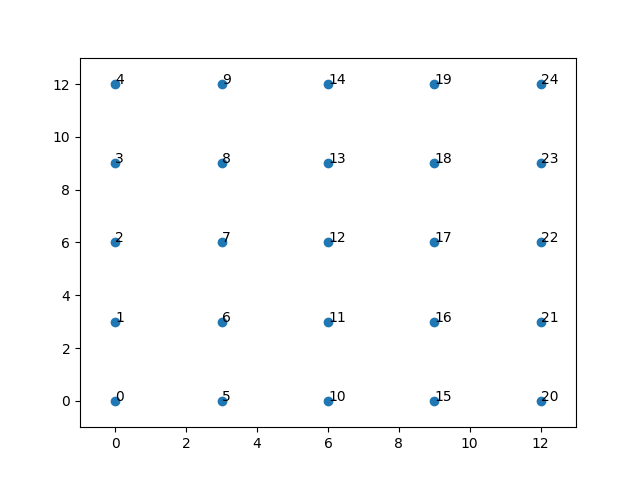

In [4]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Cursor
import matplotlib_inline
import ipympl
from matplotlib.backend_bases import MouseButton
cfig, cax = plt.subplots()
import numpy as np
from scipy.sparse import csr_array
from scipy.sparse.csgraph import dijkstra

canvas = cax.figure.canvas
background = canvas.copy_from_bbox(cax.bbox)  
x = []
y = []
nodes = []
width, height = 5, 5
numnodes = width*height
spacing = 3
for i in range(width):
    for j in range(height):
        #xrandom, yrandom = np.random.rand()*((width-1)*spacing), np.random.rand()*((height-1)*spacing)
        #nodes.append(np.asarray([xrandom, yrandom]))
        #x.append(xrandom)
        #y.append(yrandom)
        nodes.append(np.asarray([i*spacing, j*spacing]))
        x.append(i*spacing)
        y.append(j*spacing)
P_str1 = "19.40 19.06 1.21 19.20 1.18 1.28 18.48 1.52 9.35 4.89 8.98 7.82 6.39 9.11 6.32 12.32 5.95 15.59 4.28 18.31 4.04 2.27 6.63 3.87 12.42 2.27 15.49 1.35 19.27 4.55 19.17 7.65 16.71 9.49 18.93 11.84 16.75 14.05 16.78 17.29 13.54 17.53 11.43 15.25 8.26 15.52 10.92 10.17 13.71 11.67 15.72 6.59 4.45 6.83 1.69 8.19 1.72 11.40 0.22 14.09"
P_str2 = "0.86 0.93 2.57 3.58 5.90 3.53 5.84 6.62 3.01 8.13 8.64 4.94 10.15 7.80 10.29 10.99 7.96 13.17 3.48 11.31 4.93 13.64 2.51 15.88 5.66 16.56 8.76 15.77 11.98 15.12 13.33 12.14 13.07 9.28 12.92 6.12 11.42 3.26 9.06 1.28 13.98 1.37 15.49 4.14 16.02 7.18 16.02 10.43 17.67 13.20 15.01 14.85 13.72 17.80 17.91 16.45 7.23 9.99 3.60 18.98"
P_str3 = "2.5 9.8 4.7 7.1 5.1 11.2 8.2 11 11.5 10.6 9.8 7.3 7.4 4.8 1.9 5.2 3.8 2.1 6.2 0.5 8.9 1.8 11.1 3.4 0.5 1.4 2.8 0.2 0.8 3.8 4.4 4.3 6.9 2.9 10.2 5.7 1.1 7.8 3.5 6.0 5.8 8.5 9.4 4.1 11.8 1.2 7.6 6.7 9.1 8.9"
P_str4 = "19.40 19.06 1.21 19.20 1.18 1.28 18.48 1.52 9.35 4.89 8.98 7.82 6.39 9.11 6.32 12.32 5.95 15.59 4.28 18.31 4.04 2.27 6.63 3.87 12.42 2.27 15.49 1.35 19.27 4.55 19.17 7.65 16.71 9.49 18.93 11.84 16.75 14.05 16.78 17.29 13.54 17.53 11.43 15.25 8.26 15.52 10.92 10.17 13.71 11.67 15.72 6.59 4.45 6.83 1.69 8.19 1.72 11.40 0.22 14.09"
def read_pstr(p_str):
    split = p_str.split(" ")
    numnodes = int(int(len(split))/2)
    if len(split)/2 != numnodes:
        print("Error! len of p_str not even!")
    x = []
    y = []
    nodes = []
    for i in range(0, numnodes, 2):
        x.append(float(split[i]))
        y.append(float(split[i+1]))
        nodes.append(np.asarray([x[-1], y[-1]]))
    return len(nodes), x, y, nodes
#numnodes, x, y, nodes = read_pstr(P_str4)

cl = cax.scatter(x, y)
for i, txt in enumerate(nodes):
    cax.text(x[i], y[i], f"{i}")
cax.set_xlim(-1, (width-1)*spacing + 1)
cax.set_ylim(-1, (height-1)*spacing + 1)
mx1, mx2, my1, my2 = -10, -10, -10, -10
cl2 = cax.scatter([mx1, mx2], [mx2, my2], s=30, c=["red", "green"])
text=cax.text(0,-2.5, "")
toggle = True
cl3 = cax.plot([])
cl4 = cax.plot([])

graph = []
for node1 in range(numnodes):
    tmpgraph = []
    for node2 in range(numnodes):
        val = np.linalg.norm(nodes[node1]-nodes[node2])
        if val < 4.5:
            tmpgraph.append(val)
        else:
            tmpgraph.append(0)
    graph.append(tmpgraph)
csr = csr_array(graph)
dist_matrix, predecessors = dijkstra(csgraph=csr, directed=False, indices=1, return_predecessors=True)
#print(graph[1])
#print(dist_matrix)
#print(predecessors)

def dij_chain(pred, a, b):
    output = [b]
    while pred[b] > 0:
        output.append(int(pred[b]))
        b = pred[b]
    output.append(a)
    return output
#print(dij_chain(predecessors, 1, 24))

def clip(num, min, max):
    if num < min:
        return min
    elif num > max:
        return max
    else:
        return num

def nearest(num, min, max):
    clipped = clip(num, min, max)
    return round(clipped/3)

def distance(a,b):
    return(sum([(k[0]-k[1])**2 for k in zip(a,b)])**0.5)

def on_click(event):
    global toggle, mx1, my1, mx2, my2
    if event.inaxes:
        index1, index2 = -1, -1
        length = -1
        length2 = -1
        #text.set_text(f'{[[mx1*3, my1*3], [mx2*3, my2*3]]}')
        if toggle == True:
            dists = [distance([event.xdata, event.ydata],k) for k in nodes]
            mindex = dists.index(min(dists))
            print(nodes[mindex])
            mx1, my1 = int(mindex/height), mindex % height
            #mx1, my1 = nearest(event.xdata, 0, (width-1)*spacing), nearest(event.ydata, 0, (height-1)*spacing)
            toggle = False
        elif toggle == False:
            dists = [distance([event.xdata, event.ydata],k) for k in nodes]
            mindex = dists.index(min(dists))
            print(nodes[mindex])
            mx2, my2 = int(mindex/height), mindex % height
            #mx2, my2 = nearest(event.xdata, 0, (width-1)*spacing), nearest(event.ydata, 0, (height-1)*spacing)
            toggle = True

        
        cfig.canvas.restore_region(background)
        if mx1 >= 0 and mx2 >= 0:
            index1 = mx1*width + my1
            index2 = mx2*width + my2
            dist_matrix, predecessors = dijkstra(csgraph=csr, directed=False, indices=index1, return_predecessors=True)
            chain = dij_chain(predecessors, index1, index2)
            cl3data = np.asarray([nodes[node_index] for node_index in chain])
            cl4data = np.asarray([nodes[node_index] for node_index in [index1, index2]])
            cax.lines[-1].remove() # remove previous cl4
            cax.lines[-1].remove() # remove previous cl3
            cl3 = cax.plot(cl3data[:, 0], cl3data[:, 1])
            cl4 = cax.plot(cl4data[:, 0], cl4data[:, 1])
            #cl3.set_data(cl3data[:, 0], cl3data[:, 1])
            length = dist_matrix[index2]
            length2 = np.linalg.norm(nodes[index1]-nodes[index2])
        #cl2.set_offsets([[mx1*spacing, my1*spacing], [mx2*spacing, my2*spacing]])
        
        text.set_text(f'dijkstra vs actual: {length:.2f}, {length2:.2f}, {(length-length2)*100/length2:.2f}%')
        cfig.canvas.blit()

cfig.canvas.mpl_connect('button_press_event', on_click)
#cursor =  Cursor(cax, color='r')
meanpercents = []
for j in range(numnodes):
    dists, pred = dijkstra(csgraph = csr, directed=False, indices=j, return_predecessors=True)
    percents = []
    for i in range(numnodes):
        if i == j:
            continue
        length = dists[i]
        length2 = np.linalg.norm(nodes[j]-nodes[i])
        #print(length, length2)
        #if length2 > 4.5:
        percents.append(float((length-length2)*100/length2))
        #percents.append(float((length*.957-length2)*100/length2))
    meanpercents.append(np.mean(percents))
print([float(i) for i in meanpercents])
print("Mean % error of every node to every other node: ", np.mean(meanpercents))
plt.show()

In [10]:
meanpercents2 = [float(i) for i in meanpercents]
print(meanpercents2, set(meanpercents2))

[3.499618367367708, 3.629372492825112, 3.759126618282514, 3.629372492825112, 3.499618367367708, 3.6293724928251123, 3.170759573332377, 3.170759573332377, 3.170759573332377, 3.629372492825112, 3.759126618282514, 3.170759573332377, 2.6556375844544564, 3.170759573332377, 3.759126618282514, 3.629372492825112, 3.170759573332377, 3.170759573332377, 3.170759573332377, 3.629372492825111, 3.499618367367708, 3.629372492825112, 3.759126618282514, 3.629372492825112, 3.499618367367708] {2.6556375844544564, 3.629372492825112, 3.6293724928251123, 3.499618367367708, 3.170759573332377, 3.759126618282514, 3.629372492825111}


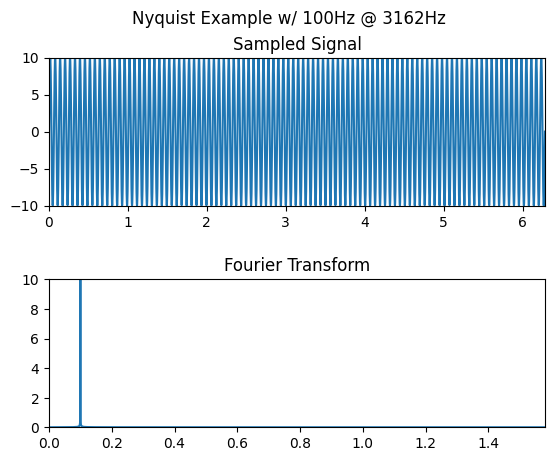

In [2]:
from scipy import signal
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import numpy as np


# animate a visualisation of nyquist frequency and the importance of sampling rate
def animate_nyquist():
    animfig, (animax1, animax2) = plt.subplots(2,1)
    lines = [animax1.plot([], [])[0]] + [animax2.plot([], [])[0]] #lines to animate
    animfig.suptitle("Nyquist Example w/ 100Hz")
    animax1.set_title("Sampled Signal")
    animax2.set_title("Fourier Transform")
    plt.subplots_adjust(hspace=0.5)
    

    
    def init():
        animax1.set_xlim(0, 2*np.pi)
        animax1.set_ylim(-10, 10)
        animax2.set_xlim(0, 200)
        animax2.set_ylim(0, 10)
        xdata = np.linspace(0, 1000, 10)
        ydata = 10*np.sin(100*xdata)
        lines[0].set_data(xdata, ydata)
        return lines
    def update(frame):
        xdata = np.linspace(0, 2*np.pi, num=frame)
        ydata = 10*np.sin(100*xdata)
        ydata2 = fft(ydata)
        xdata2 = fftfreq(frame, 1000/frame)[:frame//2]
        lines[0].set_data(xdata, ydata)
        lines[1].set_data(xdata2, 2.0/frame * np.abs(ydata2[0:frame//2]))
        animax2.set_xlim(0, xdata2[-1])
        #2.0/N * np.abs(yf[0:N//2])
        animfig.suptitle(f"Nyquist Example w/ 100Hz @ {frame}Hz")
        return lines
    ani = FuncAnimation(animfig, update, frames=np.logspace(1, 3.5, num=100).astype(int), init_func = init, blit=True)
    writergif = animation.PillowWriter(fps=5)
    ani.save("nyquist.gif", writer=writergif)
    #exit()
animate_nyquist()